### Data Analysis Pipeline

- **Create Simulation**: Represent Ancient and moderate selection.
- **Leverage Pre-trained Model**: Use pre-trained VGG-16 model. Model can be considered fit for purpose if 70% accuracy and above
- **Training Regimen**:
  - Train for 10 epochs.
  - 10 epochs each from batches 1-9 of training data.
  - Test on the final batch of unseen data.
- **40k Simulations used**
-**A100 GPU was used for this training**



In [1]:
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Navigate to the cloned repository
%cd EvoNet-CNN-Insight/model_training/Ancient_moderate

Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 5579, done.
remote: Counting objects: 100% (1200/1200), done.
remote: Compressing objects: 100% (843/843), done.
remote: Total 5579 (delta 411), reused 1113 (delta 341), pack-reused 4379
Receiving objects: 100% (5579/5579), 8.07 GiB | 55.83 MiB/s, done.
Resolving deltas: 100% (2002/2002), done.
Updating files: 100% (261/261), done.
/content/EvoNet-CNN-Insight/model_training/Ancient_moderate


In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, activations, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_fscore_support, confusion_matrix

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")


# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Run ImaGene.py

In [3]:
%run -i ../../ImaGene.py

In [ ]:
#run to make simulations
import subprocess
subprocess.call("bash ../../generate_dataset.sh params_Ancient_moderate.txt".split());

 the first iteration of training.


In [4]:

path_sim = './'

In [5]:
file_sim = ImaFile(simulations_folder=path_sim + 'AM/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Then, we populate an _ImaGene_ object by specifying the variable we want to estimate/predict (`selection_coeff_hetero`) and how many data points per class we wish to retain.
As a quick example, we will use only 2000 data points per class.

In [6]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000);

We can have a look at the data stored in this object.

In [7]:
gene_sim.summary();

An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 178, max 482, mean 320.644250, std 46.220214


In [8]:
# Filter simulations based on frequency threshold of 0.01
gene_sim.filter_freq(0.01)

# Sort simulations by row frequency
gene_sim.sort('rows_freq')

# Provide summary of the simulation data
gene_sim.summary()
# Resize simulation data to (198, 192)
gene_sim.resize((198, 192))

# Provide summary of the simulation data
gene_sim.summary()
# Convert simulation data with data augmentation (flip)
gene_sim.convert(flip=True)

# Provide summary of the simulation data
gene_sim.summary()


An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 106, max 394, mean 233.239500, std 44.035510
An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000
An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

information on the corresponding targets (in this case the selection coefficient, either 0 or selection coefficient of choice in $2N_e$ units with $N_e = 10000$).

0


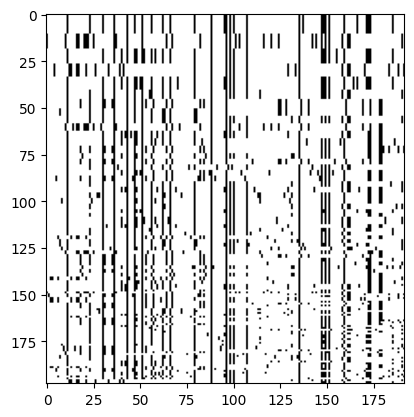

200


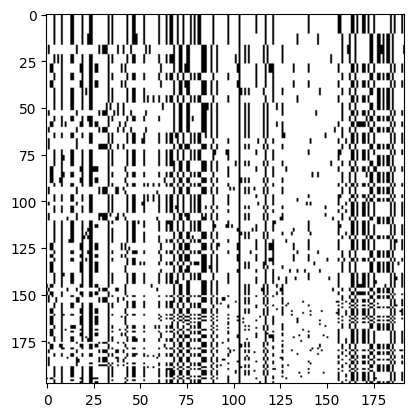

In [9]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

In [10]:
# Subset the simulation data with random indices
gene_sim.subset(get_index_random(gene_sim))

# Convert targets to binary format
gene_sim.targets = to_binary(gene_sim.targets)


Transfer Learning with VGG16 model
> Applied the data augmentation

In [11]:
# Load the VGG16 model pre-trained on ImageNet, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(198, 192, 3))

# Freeze all layers in the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Apply global average pooling to reduce the dimensions
x = Dense(128, activation='relu')(x)  # Add a dense layer with 128 units and ReLU activation
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Final layer with sigmoid activation for binary classification

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

# Create an image data generator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,  # Randomly rotate images within a range of 40 degrees
    width_shift_range=0.3,  # Randomly shift images horizontally by 30% of the width
    height_shift_range=0.3,  # Randomly shift images vertically by 30% of the height
    shear_range=0.3,  # Shear the images within 30 degrees
    zoom_range=0.3,  # Randomly zoom into images by 30%
    fill_mode='nearest'  # Fill in new pixels with the nearest pixel value
)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(gene_sim.data, gene_sim.targets, test_size=0.2, random_state=seed)

# Convert grayscale images to RGB by repeating the channels
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)

# Unfreeze the last 4 layers of the base model to allow them to be trained
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model with the Adam optimizer, binary crossentropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model to see its architecture
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 198, 192, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 198, 192, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 198, 192, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 99, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 99, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 99, 96, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 49, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 49, 48, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 49, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 49, 48, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 24, 24, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,6

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 7,145,217 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [12]:
score = model.fit(datagen.flow(X_train_rgb, y_train, batch_size=64),epochs=10, validation_data=(X_val_rgb, y_val))

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 510ms/step - accuracy: 0.5112 - loss: 0.7495 - val_accuracy: 0.6600 - val_loss: 0.6573
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 422ms/step - accuracy: 0.5720 - loss: 0.6792 - val_accuracy: 0.6750 - val_loss: 0.6031
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 423ms/step - accuracy: 0.6534 - loss: 0.6085 - val_accuracy: 0.7013 - val_loss: 0.5710
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 428ms/step - accuracy: 0.6902 - loss: 0.5760 - val_accuracy: 0.6575 - val_loss: 0.5836
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 422ms/step - accuracy: 0.6996 - loss: 0.5515 - val_accuracy: 0.7475 - val_loss: 0.5100
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 426ms/step - accuracy: 0.7038 - loss: 0.5433 - val_accuracy: 0.7487 - val_loss: 0.5014
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 425ms/step - accuracy: 0.7087 - loss: 0.5497 - val_accuracy: 0.7613 - val_loss: 0.4866
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 427ms/step - accuracy: 0.7122 - loss: 0.5404 - val_accu

In [13]:
net_LCT = ImaNet(name='AM_VGG16')


In [14]:
net_LCT.update_scores(score);

2
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 433ms/step - accuracy: 0.7333 - loss: 0.5310 - val_accuracy: 0.7550 - val_loss: 0.4888
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 423ms/step - accuracy: 0.7291 - loss: 0.5234 - val_accuracy: 0.7862 - val_loss: 0.4550
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 423ms/step - accuracy: 0.7227 - loss: 0.5370 - val_accuracy: 0.7725 - val_loss: 0.4596
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 424ms/step - accuracy: 0.7263 - loss: 0.5273 - val_accuracy: 0.7487 - val_loss: 0.5079
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 428ms/step - accuracy: 0.7533 - loss: 0.5117 - val_accuracy: 0.7287 - val_loss: 0.5172
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 423ms/step - accuracy: 0.7511 - loss: 0.4967 - val_accuracy: 0.7387 - val_loss: 0.5175
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 428ms/step - accuracy: 0.7401 - loss: 0.5189 - val_accuracy: 0.7675 - val_loss: 0.4758
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 425ms/step - accuracy: 0.7267 - loss: 0.5286 - val_ac

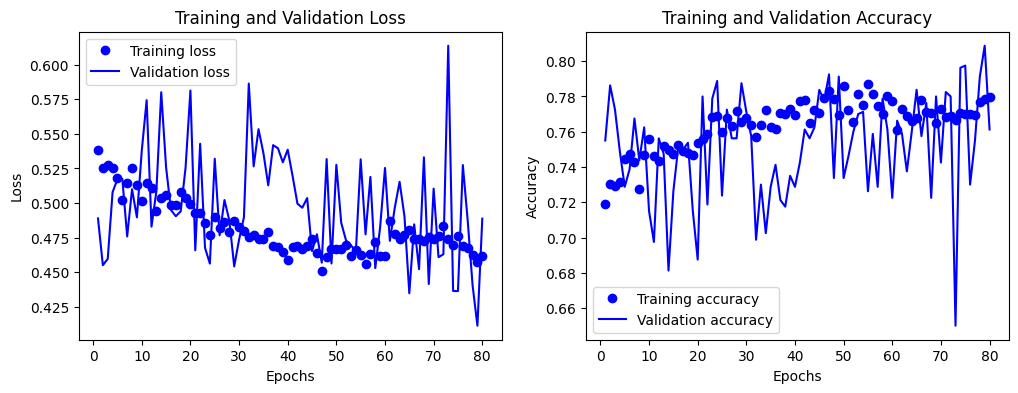

In [15]:
i = 2
all_scores = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

# Loop to iterate through different simulation datasets
while i < 10:
    print(i)

    # Create ImaFile object for the specified simulation folder and model
    file_sim = ImaFile(simulations_folder=path_sim + 'AM/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

    # Read the simulation data
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

    # Filter simulations based on frequency threshold
    gene_sim.filter_freq(0.01)

    # Sort simulations by row frequency
    gene_sim.sort('rows_freq')

    # Resize simulation data to the required dimensions
    gene_sim.resize((198, 192))

    # Convert simulation data (flip=True allows for data augmentation)
    gene_sim.convert(flip=True)

    # Get a random subset of indices and subset the simulation data
    gene_sim.subset(get_index_random(gene_sim))

    # Convert targets to binary format
    gene_sim.targets = to_binary(gene_sim.targets)

    # Train the model on the current subset of simulation data
    X_train, X_val, y_train, y_val = train_test_split(gene_sim.data, gene_sim.targets, test_size=0.2, random_state=seed)
    X_train_rgb = np.repeat(X_train, 3, axis=-1)
    X_val_rgb = np.repeat(X_val, 3, axis=-1)
    score = model.fit(datagen.flow(X_train_rgb, y_train, batch_size=64), epochs=10, validation_data=(X_val_rgb, y_val))

    # Update scores with the current training results
    all_scores['loss'].extend(score.history['loss'])
    all_scores['val_loss'].extend(score.history['val_loss'])
    all_scores['accuracy'].extend(score.history['accuracy'])
    all_scores['val_accuracy'].extend(score.history['val_accuracy'])

    # Increment the index for the next iteration
    i += 1

# Define the number of epochs for plotting
epochs = range(1, len(all_scores['loss']) + 1)

# Create a figure for plotting
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, all_scores['loss'], 'bo', label='Training loss')
plt.plot(epochs, all_scores['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, all_scores['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, all_scores['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.show()

Better Plotting visualisation

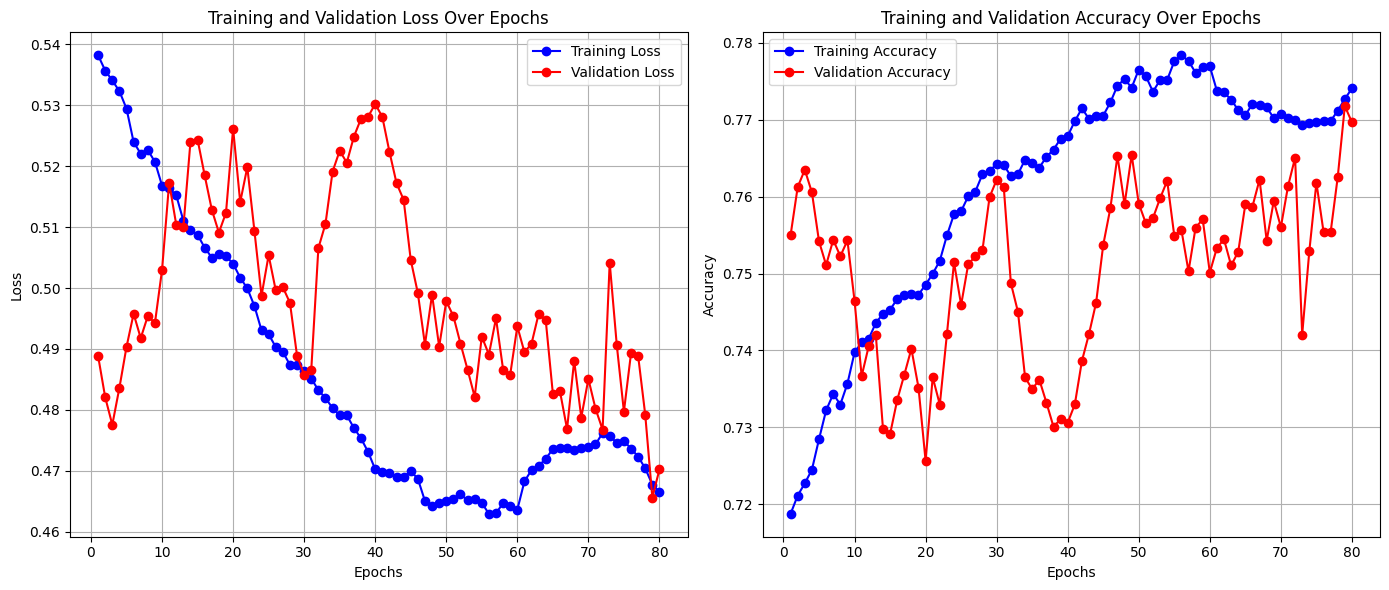

In [16]:

# Define the number of epochs for plotting
epochs = range(1, len(all_scores['loss']) + 1)

# Function to smooth the data for better visualization (optional)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Create a figure for plotting with better visualization settings
plt.figure(figsize=(14, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, smooth_curve(all_scores['loss']), 'bo-', label='Training Loss')
plt.plot(epochs, smooth_curve(all_scores['val_loss']), 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, smooth_curve(all_scores['accuracy']), 'bo-', label='Training Accuracy')
plt.plot(epochs, smooth_curve(all_scores['val_accuracy']), 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


Evaluate the training on the testing dataset, Which is the last batch of the the 10th simulation in the file
The log the testing validation and loss alongside the F1,

In [17]:
# Set the simulation index
i = 10

# Create an ImaFile object for the specified simulation folder and model
file_sim = ImaFile(simulations_folder=path_sim + 'AM/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

# Read the simulation data with the specified parameter and maximum number of replicates
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

# Filter the simulations based on a frequency threshold of 0.01
gene_sim_test.filter_freq(0.01)

# Sort the simulations by row frequency
gene_sim_test.sort('rows_freq')

# Resize the simulation data to the specified dimensions (198, 192)
gene_sim_test.resize((198, 192))

# Convert the simulation data with data augmentation (flip=True)
gene_sim_test.convert(flip=True)

# Get a random subset of indices and subset the simulation data
rnd_idx = get_index_random(gene_sim_test)  # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

# Convert the targets to binary format
gene_sim_test.targets = to_binary(gene_sim_test.targets)


In [18]:
# Evaluate the model on the test data to obtain loss and accuracy
gene_sim_test.data = np.repeat(gene_sim_test.data, 3, axis=-1)
net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)

# Print the evaluation results, which include loss and accuracy
print(net_LCT.test)  # It will report [loss, accuracy]


[0.5477182865142822, 0.7335000038146973]


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


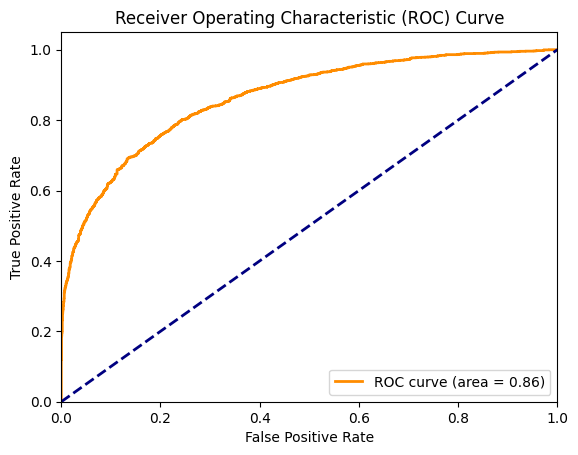

F1 Score: 0.7727078891257995
Precision: 0.6736059479553903
Recall (Sensitivity): 0.906


In [19]:
# Make predictions on the validation data
predictions = model.predict(gene_sim_test.data)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, predictions.round())

# Calculate precision, recall, and F-score
precision, recall, fscore, _ = precision_recall_fscore_support(gene_sim_test.targets, predictions.round(), average='binary')

# Recall is equivalent to sensitivity
sensitivity = recall

# Compute ROC curve and AUC (Area Under the Curve)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print additional metrics
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall (Sensitivity): {sensitivity}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


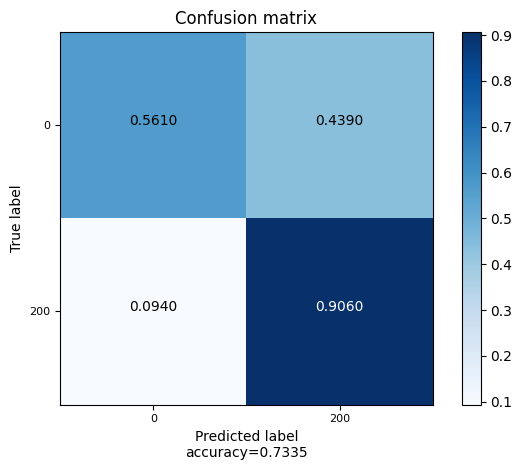

0

In [20]:
# Make predictions on the test data using the trained model and store the results in net_LCT
net_LCT.predict(gene_sim_test, model)

# Plot the confusion matrix of the predictions against the true classes, with text labels for clarity
net_LCT.plot_cm(gene_sim_test.classes, text=True)


In [21]:
path = './'
filename = 'AM_transfer_learning_vgg16.keras'

# Save the trained model to a file using the recommended Keras format
model.save(path + filename)
#Model saved to Google Drive